In [1]:
print("Importing Library...")
import torch
import torchvision
import torch.utils.data as putils

from torch import nn, optim
from torchvision import datasets,transforms
from torch.autograd import Variable
from PIL import Image
import numpy
import numpy as np
import math

print("Importing Library Success")


Importing Library...
Importing Library Success


In [2]:
print("Creating Class...")

class Codec():
    def __init__(self, size, interpolate_size, mode):
        self.size = size
        self.interpolate_size = interpolate_size
        self.mode = mode

    def btc(self, image):
        if image.shape[0] % self.size != 0:
            n = ((self.size * int(image.shape[0] / self.size)) + self.size) - image.shape[0]
            image = numpy.pad(array=image, pad_width=(0, n))

        x = image.shape[0] / self.size
        y = image.shape[1] / self.size
        block_image = numpy.split(numpy.concatenate(numpy.split(image, y, axis=1)), x * y)
        for i in range(len(block_image)):
            mean = numpy.mean(numpy.mean(block_image[i], axis=1))
            std = numpy.std(block_image[i])
            m = self.size * self.size
            q = numpy.sum(block_image[i] > mean)

            a = mean - std * numpy.sqrt(q / (m - q))
            b = mean + std * numpy.sqrt((m - q) / q)

            block_image[i][block_image[i] > mean] = b
            block_image[i][block_image[i] < mean] = a

        block_image = numpy.concatenate(block_image)
        block_image = numpy.split(block_image, x)

        temp = numpy.concatenate(block_image, axis=1)

        if image.shape[0] % self.size != 0:
            temp = temp[1:-n + 1, 1:-n + 1]

        return torch.Tensor(temp)

    def BlockTruncationCoding(self, images_tensor):
        results_tensor = images_tensor.new_empty(size=images_tensor.size())
        for i in range(len(images_tensor)):
            compact_image = images_tensor[i][0]
            compressed_image = self.btc(compact_image)
            results_tensor[i][0] = compressed_image
        return results_tensor

    def Interpolate(self, image):
        return nn.functional.interpolate(input=image, scale_factor=self.interpolate_size, mode=self.mode,
                                         align_corners=False)
    

class ODBTC():
    def __init__(self, size):
        self.size = size
        self.ditherMatrix = self.bayer(size)
        max = np.max(self.ditherMatrix)
        min = np.min(self.ditherMatrix)
        self.ditherMatrix = (self.ditherMatrix - min) / (max - min)

    def rgb2grayscale(self, image):
        temp = image[0, :, :] * 0.2989 + image[1, :, :] * 0.587 + image[2, :, :] * 0.114
        temp = temp
        return temp

    def bayer(self, normalize=True):
        matrix = self._bayer(0, 0, self.size, 0, 1)
        return matrix / (self.size * self.size) \
            if normalize else matrix

    def _bayer(self, x, y, size, value, step, matrix=None):
        if matrix is None:
            matrix = np.zeros((size, size))
        if (size == 1):
            matrix[y][x] = value
            return

        half = size // 2
        self._bayer(x, y, half, value + (step * 0), step * 4, matrix)
        self._bayer(x + half, y + half, half, value + (step * 1), step * 4, matrix)
        self._bayer(x + half, y, half, value + (step * 2), step * 4, matrix)
        self._bayer(x, y + half, half, value + (step * 3), step * 4, matrix)
        return matrix

    def calculate_single(self, image):
        grayscaleImage = self.rgb2grayscale(image)
        for i in range(len(image)):
            image[i] = self.filter(image[i], i, grayscaleImage)

        return image
    
    def __call__(self,image_batch):
        for i in range(len(image_batch)):
            image_batch[i] = self.calculate_single(image_batch[i])
        
        return image_batch
        
    def filter(self, image_channel, c, gs):
        x = image_channel.shape[0] / self.size
        y = image_channel.shape[1] / self.size
        block_image = numpy.split(numpy.concatenate(numpy.split(image_channel, y, axis=1)), x * y)
        block_image_gs = numpy.split(numpy.concatenate(numpy.split(gs, y, axis=1)), x * y)
        for i in range(len(block_image)):
            min = np.min(block_image[i])
            max = np.max(block_image[i])

            gsMin = np.min(block_image_gs[i])

            k = max - min

            temp = self.ditherMatrix.copy()

            d = (temp * k) + gsMin

            block_image[i][block_image[i] >= d] = max
            block_image[i][block_image[i] < d] = min

        block_image = numpy.concatenate(block_image)
        block_image = numpy.split(block_image, x)

        temp_last = numpy.concatenate(block_image, axis=1)

        return torch.FloatTensor(temp_last)
    

class RecCNN(nn.Module):
    def __init__(self, channel):
        super(RecCNN, self).__init__()
        self.deconv1 = nn.Conv2d(channel, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64, affine=False)
        self.deconv_n = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.bn_n = nn.BatchNorm2d(64, affine=False)
        self.deconv3 = nn.ConvTranspose2d(64, channel, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.relu(self.deconv1(x))
        for _ in range(18):
            out = self.relu(self.bn_n(self.deconv_n(out)))
        out = self.deconv3(out)
        final = out.add(x)
        return final, out
class ComCNN(nn.Module):
    def __init__(self, channel):
        super(ComCNN, self).__init__()
        self.conv1 = nn.Conv2d(channel, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(64, affine=False)
        self.conv3 = nn.Conv2d(64, channel, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.relu(self.conv1(x))
        out = self.relu(self.bn1(self.conv2(out)))
        return self.conv3(out)


def loss_function_l1(reconstructed_image,original_image):
    return nn.MSELoss(size_average=False)(reconstructed_image,original_image)

def loss_function_l2(residual_image,decoded_image,original_image):
    return nn.MSELoss(size_average=False)(residual_image,original_image-decoded_image)

def psnr(img1, img2):
    mse = numpy.mean( (img1 - img2) ** 2 )
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

import math
irange = range


def make_grid(tensor, nrow=8, padding=2,
              normalize=False, range=None, scale_each=False, pad_value=0):
    """Make a grid of images.
    Args:
        tensor (Tensor or list): 4D mini-batch Tensor of shape (B x C x H x W)
            or a list of images all of the same size.
        nrow (int, optional): Number of images displayed in each row of the grid.
            The Final grid size is (B / nrow, nrow). Default is 8.
        padding (int, optional): amount of padding. Default is 2.
        normalize (bool, optional): If True, shift the image to the range (0, 1),
            by subtracting the minimum and dividing by the maximum pixel value.
        range (tuple, optional): tuple (min, max) where min and max are numbers,
            then these numbers are used to normalize the image. By default, min and max
            are computed from the tensor.
        scale_each (bool, optional): If True, scale each image in the batch of
            images separately rather than the (min, max) over all images.
        pad_value (float, optional): Value for the padded pixels.
    Example:
        See this notebook `here <https://gist.github.com/anonymous/bf16430f7750c023141c562f3e9f2a91>`_
    """
    if not (torch.is_tensor(tensor) or
            (isinstance(tensor, list) and all(torch.is_tensor(t) for t in tensor))):
        raise TypeError('tensor or list of tensors expected, got {}'.format(type(tensor)))

    # if list of tensors, convert to a 4D mini-batch Tensor
    if isinstance(tensor, list):
        tensor = torch.stack(tensor, dim=0)

    if tensor.dim() == 2:  # single image H x W
        tensor = tensor.view(1, tensor.size(0), tensor.size(1))
    if tensor.dim() == 3:  # single image
        if tensor.size(0) == 1:  # if single-channel, convert to 3-channel
            tensor = torch.cat((tensor, tensor, tensor), 0)
        tensor = tensor.view(1, tensor.size(0), tensor.size(1), tensor.size(2))

    if tensor.dim() == 4 and tensor.size(1) == 1:  # single-channel images
        tensor = torch.cat((tensor, tensor, tensor), 1)

    if normalize is True:
        tensor = tensor.clone()  # avoid modifying tensor in-place
        if range is not None:
            assert isinstance(range, tuple), \
                "range has to be a tuple (min, max) if specified. min and max are numbers"

        def norm_ip(img, min, max):
            img.clamp_(min=min, max=max)
            img.add_(-min).div_(max - min + 1e-5)

        def norm_range(t, range):
            if range is not None:
                norm_ip(t, range[0], range[1])
            else:
                norm_ip(t, float(t.min()), float(t.max()))

        if scale_each is True:
            for t in tensor:  # loop over mini-batch dimension
                norm_range(t, range)
        else:
            norm_range(tensor, range)

    if tensor.size(0) == 1:
        return tensor.squeeze()

    # make the mini-batch of images into a grid
    nmaps = tensor.size(0)
    xmaps = min(nrow, nmaps)
    ymaps = int(math.ceil(float(nmaps) / xmaps))
    height, width = int(tensor.size(2) + padding), int(tensor.size(3) + padding)
    grid = tensor.new(3, height * ymaps + padding, width * xmaps + padding).fill_(pad_value)
    k = 0
    for y in irange(ymaps):
        for x in irange(xmaps):
            if k >= nmaps:
                break
            grid.narrow(1, y * height + padding, height - padding)\
                .narrow(2, x * width + padding, width - padding)\
                .copy_(tensor[k])
            k = k + 1
    return grid


def save_image(tensor, filename, nrow=8, padding=2,
               normalize=False, range=None, scale_each=False, pad_value=0):
    """Save a given Tensor into an image file.
    Args:
        tensor (Tensor or list): Image to be saved. If given a mini-batch tensor,
            saves the tensor as a grid of images by calling ``make_grid``.
        **kwargs: Other arguments are documented in ``make_grid``.
    """
    from PIL import Image
    grid = make_grid(tensor, nrow=nrow, padding=padding, pad_value=pad_value,
                     normalize=normalize, range=range, scale_each=scale_each)
    ndarr = grid.mul(255).clamp(0, 255).byte().permute(1, 2, 0).cpu().numpy()
    im = Image.fromarray(ndarr)
    im.save(filename)


print("Creating Class Success")
 

Creating Class...
Creating Class Success


In [3]:
print("Load Image Dataset")
image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.24703223,  0.24348513 , 0.26158784))
])

train_set = datasets.CIFAR10(root='./cifar-10-batches-py',train=True,download=True,transform=image_transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64,
                                          shuffle=True, num_workers=2)

test_set = datasets.CIFAR10(root='./cifar-10-batches-py',train=False,download=True,transform=image_transform)

test_loader = torch.utils.data.DataLoader(test_set,batch_size=64,
                                          shuffle=True,num_workers=2)

print("Load Image Dataset Success")



Load Image Dataset
Files already downloaded and verified
Files already downloaded and verified
Load Image Dataset Success


In [4]:
print("Initialize Model....")
CUDA = torch.cuda.is_available()

codec = Codec(4,2,'bicubic')
odbtc = ODBTC(4)

if CUDA:
    comCNN = ComCNN(3).cuda()
    recCNN = RecCNN(3).cuda()
    print("Cuda is available, using gpu instead")
else:
    comCNN = ComCNN(3)
    recCNN = RecCNN(3)
    print("Cuda is not available, using cpu instead")

comCNNOptimizer = optim.Adam(comCNN.parameters(),lr=1e-3)

recCNNOptimizer = optim.Adam(recCNN.parameters(),lr=1e-3)

print("Initialize Model Success")


Initialize Model....
Cuda is available, using gpu instead
Initialize Model Success


In [5]:
import time
print("Begin Training....")
epochs = 10
comCNN.train()
recCNN.train()
graph_l1 = np.empty(epochs)
graph_l2 = np.empty(epochs)
global_start = time.time()
for epoch in range(epochs):
    start = time.time()
    train_loss_1 = 0
    train_loss_2 = 0
    for batch_idx,(data,_) in enumerate(train_loader):
        data = Variable(data)
        
        compact_image = comCNN(data.cuda())
        
        compact_image_temp = compact_image.cpu().detach()
        
        # compressed_image_btc = codec.BlockTruncationCoding(compact_image_temp)
        compressed_image_odbtc = odbtc(compact_image_temp)
        upscaled_image_btc = codec.Interpolate(compressed_image_odbtc)
        
        torch.cuda.empty_cache()
        
        # update beta with eq 5
    
        recCNNOptimizer.zero_grad()
        reconstructed_image,residual = recCNN(upscaled_image_btc.cuda())
        loss2 = loss_function_l2(
            residual_image=residual,
            decoded_image=upscaled_image_btc.cuda(),
            original_image=data.cuda()
        )
        loss2.backward()
        
        train_loss_2 += loss2.item()
        recCNNOptimizer.step()
    
    
        comCNNOptimizer.zero_grad()
        upscaled_image_nonbtc = codec.Interpolate(compact_image)
        reconstructed_without_btc,_ = recCNN(upscaled_image_nonbtc.cuda())
        loss1 = loss_function_l1(
            reconstructed_image=reconstructed_without_btc.cuda(),
            original_image=data.cuda()
        )
        loss1.backward()
        train_loss_1 += loss1.item()
        comCNNOptimizer.step()
        # print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} - {:.6f}'.format(
        #         epoch, batch_idx * len(data), len(train_loader.dataset),
        #         100. * batch_idx / len(train_loader),
        #         loss1.item() / len(data) , loss2.item()/len(data)))
    end = time.time()
    graph_l1[epoch] = train_loss_1/len(train_loader.dataset)
    graph_l2[epoch] = train_loss_2/len(train_loader.dataset)
    print('====> Epoch: {}\nAverage loss 1: {:.4f}\nAverage Loss 2: {:.4f}\nRunning Time : {}'.format(
          epoch, train_loss_1/len(train_loader.dataset),train_loss_2/len(train_loader.dataset),(end-start)))

global_end = time.time()
print("\n========>Training Complete....")
print('Total Running Time : {}'.format((global_end-global_start)))

Begin Training....
====> Epoch: 0
Average loss 1: 1914872.6922
Average Loss 2: 1034235.0263
Running Time : 400.02381324768066


d:\pycharmprojects\end-to-end-compression-framework\venv\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


KeyboardInterrupt: 

In [6]:
print("Saving Model...")
torch.save(comCNN,'../model/ComCNN-with-odbtc[normalize]32x32.pt')
torch.save(recCNN,'../model/RecCNN-with-odbtc[normalize]32x32.pt')
print("Model saved")

Saving Model...
Model saved


d:\pycharmprojects\end-to-end-compression-framework\venv\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type ComCNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
d:\pycharmprojects\end-to-end-compression-framework\venv\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type RecCNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


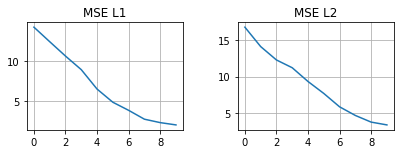

In [8]:
import matplotlib.pyplot as plt
plt.figure(1)

plt.subplot(221)
plt.plot(graph_l1)
plt.title("MSE L1")
plt.grid(True)

plt.subplot(222)
plt.plot(graph_l2)
plt.title('MSE L2')
plt.grid(True)
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
plt.show()


In [9]:
print("Load trained model...")
trainedComCNN = torch.load('../model/ComCNN-with-odbtc[normalize]32x32.pt')
trainedRecCNN = torch.load('../model/RecCNN-with-odbtc[normalize]32x32.pt')
# codec = Codec(4,2,'bicubic')
print("Load success")

Load trained model...
Load success


In [14]:
import time
trainedComCNN.eval()
trainedRecCNN.eval()
print("Begin Testing....")

graph_l1_test = np.empty(len(test_loader.dataset))
graph_l2_test = np.empty(len(test_loader.dataset))
global_start = time.time()

i = 0

for batch_idx,(data,_) in enumerate(train_loader):
    data = Variable(data)
    compact_image = trainedComCNN(data.cuda())
    compact_image_temp = compact_image.cpu().detach()
    # compressed_image_btc = codec.BlockTruncationCoding(compact_image_temp)
    compressed_image_odbtc = odbtc(compact_image_temp)
    upscaled_image_btc = codec.Interpolate(compressed_image_odbtc)
    
    
    reconstructed_image,residual = trainedRecCNN(upscaled_image_btc.cuda())
    loss2 = loss_function_l2(
            residual_image=residual,
            decoded_image=upscaled_image_btc.cuda(),
            original_image=data.cuda()
        )
    
    upscaled_image_nonbtc = codec.Interpolate(compact_image)
    reconstructed_without_btc,_ = trainedRecCNN(upscaled_image_nonbtc.cuda())
    loss1 = loss_function_l1(
            reconstructed_image=reconstructed_without_btc.cuda(),
            original_image=data.cuda()
        )
    
    graph_l1_test[i] = loss1.item()
    
    graph_l2_test[i] = loss2.item()
    i+=1
    
    
    
global_end = time.time()
print("\n========>Teesting Complete....")
print('Total Running Time : {}'.format((global_end-global_start)))
print('Loss Function ComCNN Average : {}'.format(np.sum(graph_l1_test)/len(test_loader.dataset)))
print('Loss Function RecCNN Average : {}'.format(np.sum(graph_l1_test)/len(test_loader.dataset)))

Begin Testing....

========>Teesting Complete....
Total Running Time : 212.17981219291687
Loss Function ComCNN Average : 10273.4110609375
Loss Function RecCNN Average : 10273.4110609375


In [1]:
psnr_total = 0
for batch_idx,(data,_) in enumerate(test_loader):
    data = Variable(data)
    
    compact_image = trainedComCNN(data.cuda())
    compact_image_temp = compact_image.cpu().detach()
    # compressed_image_btc = codec.BlockTruncationCoding(compact_image_temp)
    compressed_image_odbtc = odbtc(compact_image_temp)
    upscaled_image_btc = codec.Interpolate(compressed_image_odbtc)
    
    
    reconstructed_image,residual = trainedRecCNN(upscaled_image_btc.cuda())
    
    upscaled_image_nonbtc = codec.Interpolate(compact_image)
    reconstructed_without_btc,_ = trainedRecCNN(upscaled_image_nonbtc.cuda())
    
    
    for i in range(len(data)):
        img1 = reconstructed_image[i][0].cpu().detach().numpy()
        img2 = data[i][0].cpu().detach().numpy()
        psnr_temp = psnr(img1,img2)
        print("Test Set {} -> psnr : {}".format(i,psnr_temp))
        psnr_total += psnr_temp
        save_image(data[i],'../result/end-to-end-with-odbtc[normalize]32x32/ori-{}.png'.format(i))
        save_image(reconstructed_image[i],'../result/end-to-end-with-odbtc[normalize]32x32/recon-{}.png'.format(i))
    
    save_image(data[:],'../result/end-to-end-with-odbtc[normalize]32x32/original.png')    
    save_image(reconstructed_image[:],'../result/end-to-end-with-odbtc[normalize]32x32/recon.png')

print("Average psnr : {}".format(psnr_total/len(test_loader.dataset)))

NameError: name 'test_loader' is not defined